# How to show a TESS Observability Map

`tesswcs` is a tool to provide you with the World Coordinate System (WCS) for all past TESS observations, and predict the WCS of future observations. This notebook shows how to use `tesswcs` to plot how much of the sky has been observed by TESS by the end of Cycle 7 observations. 

In [2]:
import tesswcs
from tesswcs.locate import get_observability_mask
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm import tqdm

Make sure you're using the most recent version, (1.1.7 or higher)

In [3]:
tesswcs.__version__

'1.1.7'

In [4]:
# All the TESS pointings
pointings = tesswcs.pointings[['RA', "Dec", "Roll"]].to_pandas().values

/Users/chedges/miniforge3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


To plot observability we will need a grid of RAs and Decs over the sky to check. I've just done a uniform grid in RA and Dec, which is not ideal, you could switch this to a different method.

In [28]:
# Grid of RA and Dec to check
# 2000 points in RA
# 1201 points in Dec

# If you increase the resolution this will take longer to calculate.
RA, Dec = np.mgrid[:360:2000j, -90:90:1201j]

Below we loop through all the pointings, cameras, and CCDs and calculate which points in the RA and Dec grid fall on a camera. This can take a few minutes depending on the resolution of the grid. 

In [25]:
# Array to accumulate number of observations
nobs = np.zeros(RA.shape, dtype=float)
# Loop through all the ra, dec and roll of the pointings
for ra, dec, roll in tqdm(pointings, desc='Pointing', leave=True, position=0):
    # Loop through each camera
    for camera in np.arange(1, 5):
        # Loop through each CCD
        for ccd in np.arange(1, 5):
            wcs = tesswcs.WCS.predict(ra, dec, roll, camera, ccd)    
            mask = get_observability_mask(wcs, SkyCoord(RA, Dec, unit='deg')).astype(int)
            nobs += mask

Pointing: 100%|█████████████████████████████████| 96/96 [04:03<00:00,  2.53s/it]


Now we have finished, `nobs` is the number of times TESS is able to observe that point in the sky. We can plot this map;

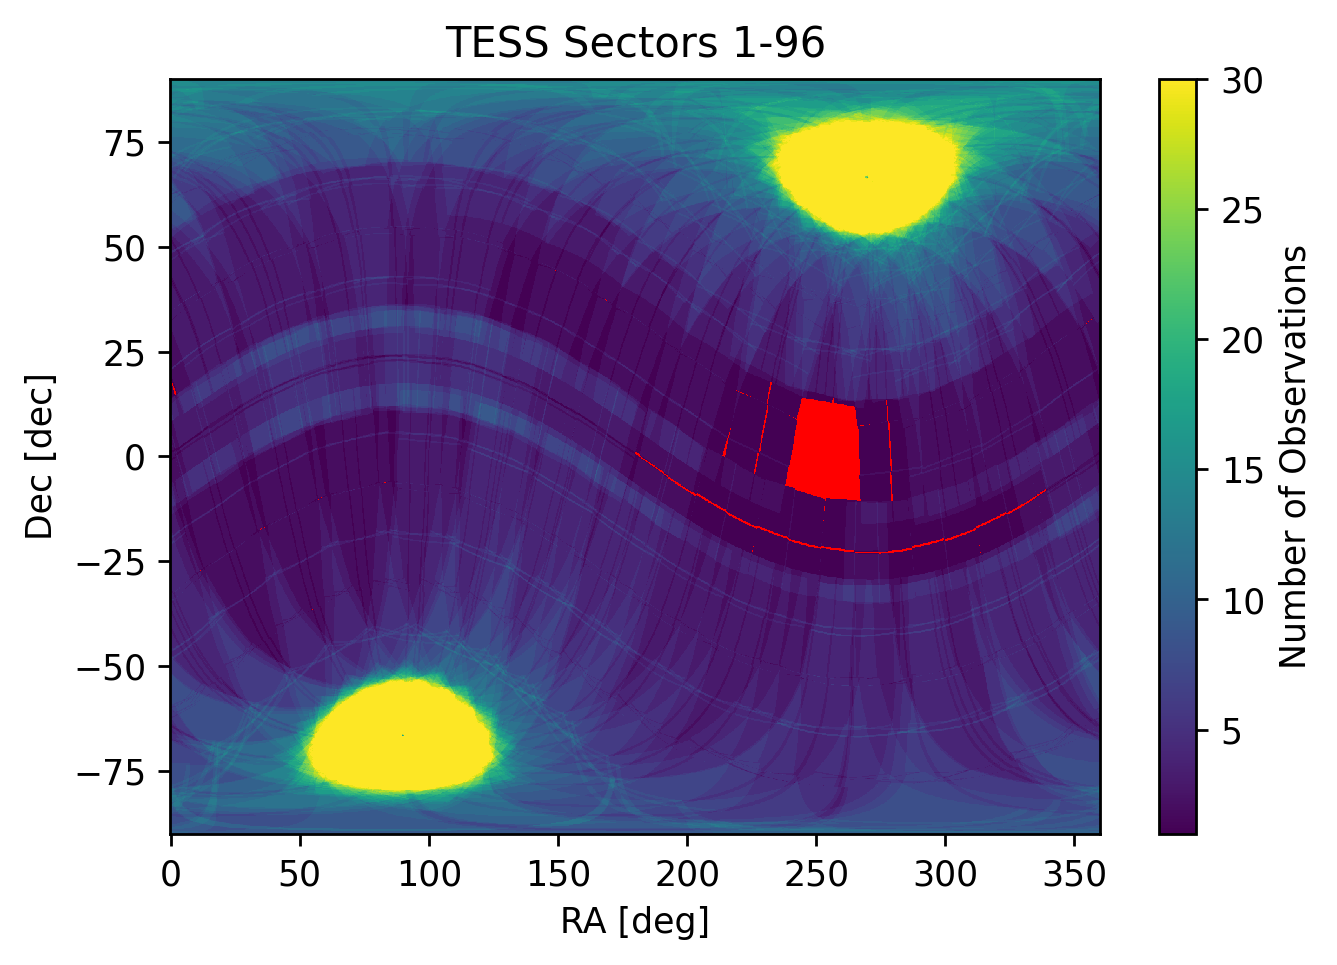

In [30]:
fig, ax = plt.subplots(dpi=250)
cmap = plt.get_cmap('viridis')
cmap.set_extremes(under='r')
im = ax.pcolormesh(RA, Dec, nobs, cmap=cmap, vmin=1, vmax=30, shading='nearest')
cbar = plt.colorbar(im, ax=ax)
ax.set(xlabel='RA [deg]', ylabel='Dec [dec]', title=f"TESS Sectors 1-{tesswcs.pointings['Sector'].max()}")
cbar.set_label("Number of Observations")

If we sum up the number of points that are not zero, we get the sky coverage.

In [27]:
print(100*(nobs!=0).sum()/np.prod(nobs.shape), "% of the sky observed by the end of Cycle 7")

98.94787676935887 % of the sky observed by the end of Cycle 7
